logistic regression on mnist using batchflow over pytorch via model body redefenition

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../../batchflow')

from batchflow import B, V, Pipeline, Config
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch.layers import Dense
from batchflow.models.torch import TorchModel
from batchflow.opensets import MNIST
from batchflow import best_practice

In [2]:
BATCH_SIZE = 64
mnist = MNIST()

ExtractingExtracting Downloading /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-images-idx3-ubyte.gz
 http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
ExtractingExtracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-labels-idx1-ubyte.gz /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-labels-idx1-ubyte.gz

/var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-images-idx3-ubyte.gz


In [3]:
class MyModel(TorchModel):
    @classmethod
    def body(cls, **kwargs):
        kwargs = cls.get_defaults('body', kwargs)
        return Dense(inputs=kwargs['inputs'], units=kwargs['units'])

In [4]:
model_config = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'loss': 'ce',
    'optimizer': 'Adam',
    'initial_block/inputs': 'images',
    'body/units': 10,
    'output': dict(predicted=['proba', 'labels'])
}

In [5]:
train_pipeline = (mnist.train.p
    .init_variable('loss_history', init_on_each_run=list)
    .init_model('dynamic', MyModel, 'my_model', model_config)
    .to_array('float32', 'channels_first')
    .train_model('my_model', B('images'), B('labels'), fetches='loss', save_to=V('loss_history'), mode='a')
)

In [6]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, bar=True);

100%|█████████▉| 937/938 [00:08<00:00, 107.44it/s]


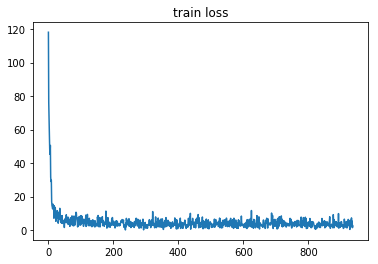

In [15]:
plt.plot(train_pipeline.get_variable('loss_history'));
plt.title('train loss');

In [8]:
test_pipeline = (mnist.test.p
    .init_variable('predictions')
    .init_variable('metrics')
    .import_model('my_model', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('my_model', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=1, save_to=V('metrics'), mode='u')
)

In [9]:
test_pipeline.run(BATCH_SIZE, n_epochs=1);

In [10]:
metrics = test_pipeline.get_variable('metrics')

In [11]:
metrics._confusion_matrix

array([[[ 880,    0,    5,    1,    0,    6,    4,    1,    4,    2],
        [   0, 1098,    9,    0,    2,    2,    1,    8,    7,    4],
        [   4,    2,  861,   15,    7,    1,    5,   11,    3,    5],
        [   4,    4,   46,  860,    4,   23,    2,   12,   23,    5],
        [   0,    0,    5,    0,  849,    2,    3,    0,    4,   24],
        [  44,    6,   10,   82,    6,  787,   14,    3,   98,   30],
        [  35,    5,   23,    6,   32,   33,  927,    1,   35,    1],
        [   5,    2,   14,   12,   10,    5,    1,  958,   16,   41],
        [   5,   14,   54,   16,   14,   26,    1,    5,  755,    6],
        [   3,    4,    5,   18,   58,    7,    0,   29,   29,  891]]])

In [12]:
metrics.evaluate('accuracy')

0.8866

In [20]:
metrics.evaluate(['true_positive_rate', 'true_negative_rate',
                  'false_positive_rate', 'false_negative_rate'], multiclass=None)

{'false_negative_rate': array([0.10204082, 0.03259912, 0.16569767, 0.14851485, 0.13543788,
        0.117713  , 0.03235908, 0.06809339, 0.224846  , 0.11694747]),
 'false_positive_rate': array([0.00254989, 0.0037225 , 0.0059099 , 0.01368187, 0.00421379,
        0.03216952, 0.01891175, 0.01181453, 0.01562154, 0.01701702]),
 'true_negative_rate': array([0.99745011, 0.9962775 , 0.9940901 , 0.98631813, 0.99578621,
        0.96783048, 0.98108825, 0.98818547, 0.98437846, 0.98298298]),
 'true_positive_rate': array([0.89795918, 0.96740088, 0.83430233, 0.85148515, 0.86456212,
        0.882287  , 0.96764092, 0.93190661, 0.775154  , 0.88305253])}

In [24]:
train_pipeline.save_model('my_model', path='../models/body redef')